# Assignment 1 -- ML4F 2021

## Instructions
* This assignment covers the material discussed in Lectures ML1 and ML2. 
* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment1_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment1_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment1_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`.
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate it.
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Introduction

According to Wikipedia, the definition of a stock is: 
“Stock (also capital stock) is all of the shares into which ownership of a corporation is divided. In American English, the shares are collectively known as "stock". A single share of the stock represents fractional ownership of the corporation in proportion to the total number of shares.”
Some people trade with these stocks. But when is it worth to buy such one? What influence the prices of those stocks? In this assignment you will predict whether a stock is worth to buy or not. 
There are a lot of variables to choose from. The goal is to predict the column ‘class’. This is an indicator whether to buy the stock in the next period or not. 




Let's load and have a look at the data.

In [2]:
path = os.path.join('data','stocks.xlsx')

df_data = pd.read_excel(path)
df_data

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Class
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,2.851000e+09,0
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,3.955957e+07,0
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,7.510000e+08,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,8.040000e+05,1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,8.833000e+08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,TSRI,4.952987e+07,0.1028,4.125164e+07,8.278229e+06,0.000000e+00,8.253061e+06,8.253061e+06,2.516800e+04,0.000000e+00,-6.893600e+04,1.700000e+04,1
3804,TZOO,1.532400e+08,-0.1019,1.917400e+07,1.340660e+08,1.132600e+07,1.125130e+08,1.162560e+08,1.781000e+07,0.000000e+00,1.790100e+07,4.839000e+06,0
3805,USATP,4.200000e+07,NaN,2.700000e+07,1.500000e+07,NaN,1.400000e+07,1.500000e+07,0.000000e+00,0.000000e+00,0.000000e+00,-2.700000e+07,0
3806,WSTG,3.407580e+08,0.1344,3.159480e+08,2.481000e+07,0.000000e+00,1.651300e+07,1.651300e+07,8.297000e+06,-4.720000e+05,8.758000e+06,2.998000e+06,1


## Preparation

Before we start the analysis, we prepare the data by labelling them correctly and splitting into targets and features.

In [3]:
target_name = 'Class'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

# Question 1
(30 points)


As you learned in the lectures, preprocessing the data set is an important set to use machine learning models. Why is this important? 

Preprocessing the data set is important because it affects the ability of our model to learn. An optimization algorithm will focus on the weight of the feature with a very large range. The shape of the weights will determine the cost function, which will create a large elipse for features with a large range. Two common approaches to preprocess the data are normalization or standarization.

Use the methods discussed in ML2 to preprocess the data. Make descriptive statistics and histograms etc to find out more about the distributions of the data. Discuss your output: are there outliers etc? Then choose what preprocessing to apply.


In [4]:
# Answer

In [5]:
df_data.dtypes

Unnamed: 0              object
Revenue                float64
Revenue Growth         float64
Cost of Revenue        float64
Gross Profit           float64
R&D Expenses           float64
SG&A Expense           float64
Operating Expenses     float64
Operating Income       float64
Interest Expense       float64
Earnings before Tax    float64
Income Tax Expense     float64
Class                    int64
dtype: object

In [6]:
stats = pd.DataFrame(df_data.describe(include='all'))
stats

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Class
count,3808,3.761000e+03,3.572000e+03,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.741000e+03,3.753000e+03,3.745000e+03,3.728000e+03,3.742000e+03,3808.000000
unique,3808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ATRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.918622e+18,-2.820193e+03,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,-5.999198e+26,6.748248e+08,1.002018e+08,5.725866e+08,1.762750e+08,0.429097
std,NaN,2.398954e+20,1.673319e+05,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.031507e+28,3.786291e+09,6.991091e+08,2.793740e+09,1.011342e+09,0.495012
min,NaN,-6.276160e+08,-1.000000e+07,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-3.948300e+30,-6.786000e+09,-2.250000e+08,-8.878000e+09,-2.081114e+09,0.000000
25%,NaN,5.793000e+07,-2.350000e-03,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,0.000000e+00,0.000000
50%,NaN,4.385430e+08,6.185000e-02,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386820e+08,4.104400e+07,2.563000e+06,2.842700e+07,5.335000e+06,0.000000
75%,NaN,2.395500e+09,1.888750e-01,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,5.752550e+07,1.000000


array([[<AxesSubplot:title={'center':'Revenue'}>,
        <AxesSubplot:title={'center':'Revenue Growth'}>,
        <AxesSubplot:title={'center':'Cost of Revenue'}>],
       [<AxesSubplot:title={'center':'Gross Profit'}>,
        <AxesSubplot:title={'center':'R&D Expenses'}>,
        <AxesSubplot:title={'center':'SG&A Expense'}>],
       [<AxesSubplot:title={'center':'Operating Expenses'}>,
        <AxesSubplot:title={'center':'Operating Income'}>,
        <AxesSubplot:title={'center':'Interest Expense'}>],
       [<AxesSubplot:title={'center':'Earnings before Tax'}>,
        <AxesSubplot:title={'center':'Income Tax Expense'}>,
        <AxesSubplot:title={'center':'Class'}>]], dtype=object)

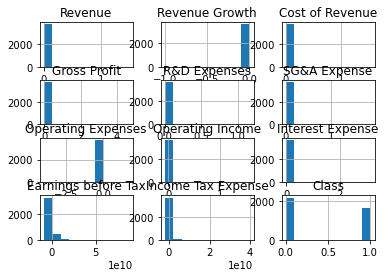

In [7]:
df_data.hist()

Since the values are very high, standardization is applied on all columns except for the 'Class' and 'Unnamed:0'. Using standardization, the values can be compared. 

In [8]:
df_x = df_data[["Revenue","Revenue Growth","Cost of Revenue","Gross Profit","R&D Expenses","SG&A Expense","Operating Expenses","Operating Income","Interest Expense","Earnings before Tax","Income Tax Expense"]]

In [9]:
df_data[["Revenue","Revenue Growth","Cost of Revenue","Gross Profit","R&D Expenses","SG&A Expense","Operating Expenses","Operating Income","Interest Expense","Earnings before Tax","Income Tax Expense"]] = (df_x-df_x.mean())/df_x.std()

In [10]:
df_data_st = df_data

In [11]:
df_data_st

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Class
0,PG,-0.016335,0.016853,1.161876,2.862985,-0.146699,4.258570,0.008532,3.495552,0.870820,4.983074,2.644728,0
1,VIPS,-0.016335,0.016861,-0.029446,-0.108685,0.022331,-0.121678,0.008532,-0.142680,-0.125950,-0.142177,-0.135182,0
2,KR,-0.016335,0.016854,2.448032,1.557235,-0.146699,2.959028,0.008532,0.541473,0.490336,0.607577,0.568280,1
3,RAD,-0.016335,0.016854,0.476922,0.443089,-0.146699,1.167912,0.008532,0.016488,0.464004,-0.115390,-0.173503,1
4,GIS,-0.016335,0.016854,0.257798,0.360784,-0.146699,0.527608,0.008532,0.602853,0.289223,0.764249,0.699096,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,TSRI,-0.016335,0.016855,-0.120358,-0.188083,-0.146699,-0.191351,0.008532,-0.178222,-0.143328,-0.204978,-0.174281,1
3804,TZOO,-0.016335,0.016853,-0.121084,-0.177230,-0.129027,-0.169724,0.008532,-0.173525,-0.143328,-0.198546,-0.169513,0
3805,USATP,-0.016335,NaN,-0.120827,-0.187503,NaN,-0.190159,0.008532,-0.178228,-0.143328,-0.204953,-0.200995,0
3806,WSTG,-0.016335,0.016855,-0.111324,-0.186657,-0.146699,-0.189637,0.008532,-0.176037,-0.144003,-0.201819,-0.171334,1


In [12]:
stats_standardized = pd.DataFrame(df_data_st.describe(include='all'))
stats_standardized

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Class
count,3808,3.761000e+03,3.572000e+03,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.741000e+03,3.753000e+03,3.745000e+03,3.728000e+03,3.742000e+03,3808.000000
unique,3808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ATRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-4.838868e-17,-1.165256e-17,3.637066e-17,2.912266e-17,4.965920e-16,1.639052e-16,7.814890e-16,3.680036e-17,2.071848e-16,9.081612e-17,-2.809529e-16,0.429097
std,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.495012
min,NaN,-1.633471e-02,-5.974465e+01,-1.396574e-01,-2.841360e-01,-1.469334e-01,-1.930625e-01,-5.614301e+01,-1.970484e+00,-4.651660e-01,-3.382772e+00,-2.232072e+00,0.000000
25%,NaN,-1.633471e-02,1.685388e-02,-1.216119e-01,-1.861289e-01,-1.466993e-01,-1.898497e-01,8.531881e-03,-1.785739e-01,-1.433279e-01,-2.062896e-01,-1.742981e-01,0.000000
50%,NaN,-1.633471e-02,1.685426e-02,-1.170633e-01,-1.723288e-01,-1.466993e-01,-1.777506e-01,8.531881e-03,-1.673883e-01,-1.396618e-01,-1.947782e-01,-1.690229e-01,0.000000
75%,NaN,-1.633471e-02,1.685502e-02,-8.225536e-02,-1.118145e-01,-1.312349e-01,-1.202550e-01,8.531881e-03,-1.065758e-01,-8.182099e-02,-1.264266e-01,-1.174177e-01,1.000000


array([[<AxesSubplot:title={'center':'Revenue'}>,
        <AxesSubplot:title={'center':'Revenue Growth'}>,
        <AxesSubplot:title={'center':'Cost of Revenue'}>],
       [<AxesSubplot:title={'center':'Gross Profit'}>,
        <AxesSubplot:title={'center':'R&D Expenses'}>,
        <AxesSubplot:title={'center':'SG&A Expense'}>],
       [<AxesSubplot:title={'center':'Operating Expenses'}>,
        <AxesSubplot:title={'center':'Operating Income'}>,
        <AxesSubplot:title={'center':'Interest Expense'}>],
       [<AxesSubplot:title={'center':'Earnings before Tax'}>,
        <AxesSubplot:title={'center':'Income Tax Expense'}>,
        <AxesSubplot:title={'center':'Class'}>]], dtype=object)

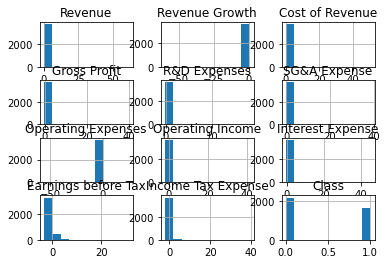

In [13]:
df_data_st.hist()

There are definitely outliers in the dataset. 

Which features will you use to make your predictions? Looking at a correlation matrix might help: df_date.corr gives a correlation matrix of the dataframe. Other feature selection approaches are also fine. Explain your choices.  

In [14]:
# Answer

Why should you make a training and a test set?

In [15]:
# Answer

Make a training and test set. Describe briefly what parameters these sets have: how many observations in both sets?

In [16]:
# Answer

# Question 2
(10 points)

Estimate a Logistic regression model with the target variable 'class'. Use the User Guide of Scikit-learn for the syntax and the training set of the previous question. What are the estimated coefficients? 

In [17]:
# Answer

---

# Question 3
(30 points)

Make predictions for the test set. 

In [18]:
# Answer

Discuss the results in terms of investment advice: would you put your money on your algorithm?

In [19]:
# Answer

Feature engineering can also be helpful to make better predictions. Define at least 2 new features with the features given in the dataset. 


In [20]:
# Answer

Use the new features and rerun the classification. Does the new features improve the predictions? Is it possible that it does worse? Please explain.

In [21]:
# Answer

# Question 4
(10 points)

Run the same model as in the previous question but set the tolerance for stopping criteria on 0.01 instead of the default one of 1e-4. Discuss these results in relation to the default: what is different? Why?

In [22]:
# Answer

# Question 5
(20 points)

Compute the confusion matrix of the model estimated in Question 4.  
Compute precision and recall for this case.

In [23]:
# Answer

In [24]:
# Answer

---